In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
%matplotlib inline

In [220]:
data = pd.read_csv("data/train_data.csv").rename(columns = {'SalePrice':'price'})
price = data.price
data.drop('price', axis=1, inplace=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Simplest approach

1. log-tranform skew data
2. fill missing values with feature mean
3. make dummy variables

(array([   5.,   12.,   54.,  184.,  470.,  400.,  220.,   90.,   19.,    6.]),
 array([ 10.46027076,  10.76769112,  11.07511148,  11.38253184,
         11.6899522 ,  11.99737256,  12.30479292,  12.61221328,
         12.91963363,  13.22705399,  13.53447435]),
 <a list of 10 Patch objects>)

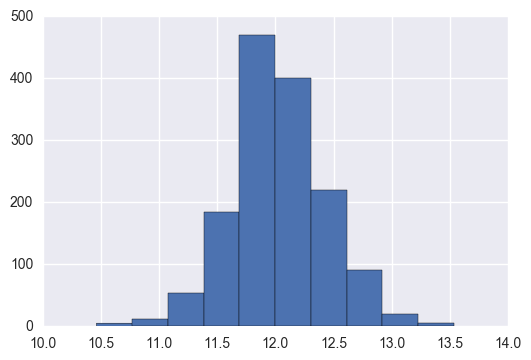

In [162]:
price = np.log1p(price)
plt.hist(price)

In [163]:
#drop features that have more that 15% missing values
prop_na = data.isnull().sum()/len(data)
data = data.drop(prop_na[prop_na>0.15].index, axis=1)

In [164]:
#get numeric features and log tranform all that have a skew of more than 0.75
numeric_feats = data.drop('Id', axis=1).dtypes[data.dtypes!=object].index
categorical_feats = data.drop('Id', axis=1).dtypes[data.dtypes==object].index
skewed_feats = data[numeric_feats].skew()>0.75
skewed_feats = skewed_feats[skewed_feats].index
data[skewed_feats] = np.log1p(data[skewed_feats])

In [166]:
#Get dummy variables
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
mat = data[categorical_feats].to_dict(orient='records')
vec.fit(mat)
encoded = vec.transform(mat)
encoded_df = pd.DataFrame(encoded.todense())
encoded_df.columns = vec.get_feature_names()
data = pd.concat([data, encoded_df], axis=1)
encoded_df.head()

/Users/Vasilis/anaconda3/envs/ds100/lib/python3.5/site-packages/pandas/core/frame.py:882: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,BldgType=TwnhsE,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,...,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,Street=Grvl,Street=Pave,Utilities=AllPub,Utilities=NoSeWa
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [184]:
# impute the mean for missing values.\
data = data.drop(categorical_feats, axis=1)
data = data.fillna(data.mean())

In [191]:
data.GarageYrBlt = data.GarageYrBlt.fillna(round(data.GarageYrBlt.mean()))
data.MasVnrArea = data.MasVnrArea.fillna(data.MasVnrArea.mean())

In [210]:
def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [208]:
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

X = data.as_matrix()
y = price

alphas = np.logspace(-3,1, 20)
ridge = RidgeCV(alphas=alphas, normalize=True, cv=5)
ridge.fit(X,y)

RidgeCV(alphas=array([  1.00000e-03,   1.62378e-03,   2.63665e-03,   4.28133e-03,
         6.95193e-03,   1.12884e-02,   1.83298e-02,   2.97635e-02,
         4.83293e-02,   7.84760e-02,   1.27427e-01,   2.06914e-01,
         3.35982e-01,   5.45559e-01,   8.85867e-01,   1.43845e+00,
         2.33572e+00,   3.79269e+00,   6.15848e+00,   1.00000e+01]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=True, scoring=None,
    store_cv_values=False)

In [212]:
rmse_cv(ridge, X, y).mean()

0.12669396938699912

In [215]:
lasso = LassoCV(alphas=alphas).fit(X,y)
rmse_cv(lasso, X, y).mean()

0.12379595955531111

In [218]:
print("Lasso selected",sum(lasso.coef_>0), " non-zero features")
print(data.columns[lasso.coef_>0])

Lasso selected 63  non-zero features
Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'BldgType=1Fam',
       'BsmtExposure=Gd', 'BsmtQual=Ex', 'CentralAir=Y', 'Condition1=Norm',
       'ExterCond=TA', 'Exterior1st=BrkFace', 'Exterior1st=MetalSd',
       'Foundation=PConc', 'Functional=Typ', 'GarageCond=TA', 'HeatingQC=Ex',
       'KitchenQual=Ex', 'LotConfig=CulDSac', 'Neighborhood=BrkSide',
       'Neighborhood=Crawfor', 'Neighborhood=NoRidge', 'Neighborhood=NridgHt',
       'Neighborhood=Somerst', 'Neighborhood=StoneBr', 'PavedDrive=Y',
       'SaleCondition=Normal', 'SaleType=New', 'BldgType=1Fam', 'CentralAir=Y',
       'Condition1=Norm', 'ExterCond=TA', 'Exterior1st=BrkFace',
       'Exte

LassoCV(alphas=array([  1.00000e-03,   1.62378e-03,   2.63665e-03,   4.28133e-03,
         6.95193e-03,   1.12884e-02,   1.83298e-02,   2.97635e-02,
         4.83293e-02,   7.84760e-02,   1.27427e-01,   2.06914e-01,
         3.35982e-01,   5.45559e-01,   8.85867e-01,   1.43845e+00,
         2.33572e+00,   3.79269e+00,   6.15848e+00,   1.00000e+01]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)